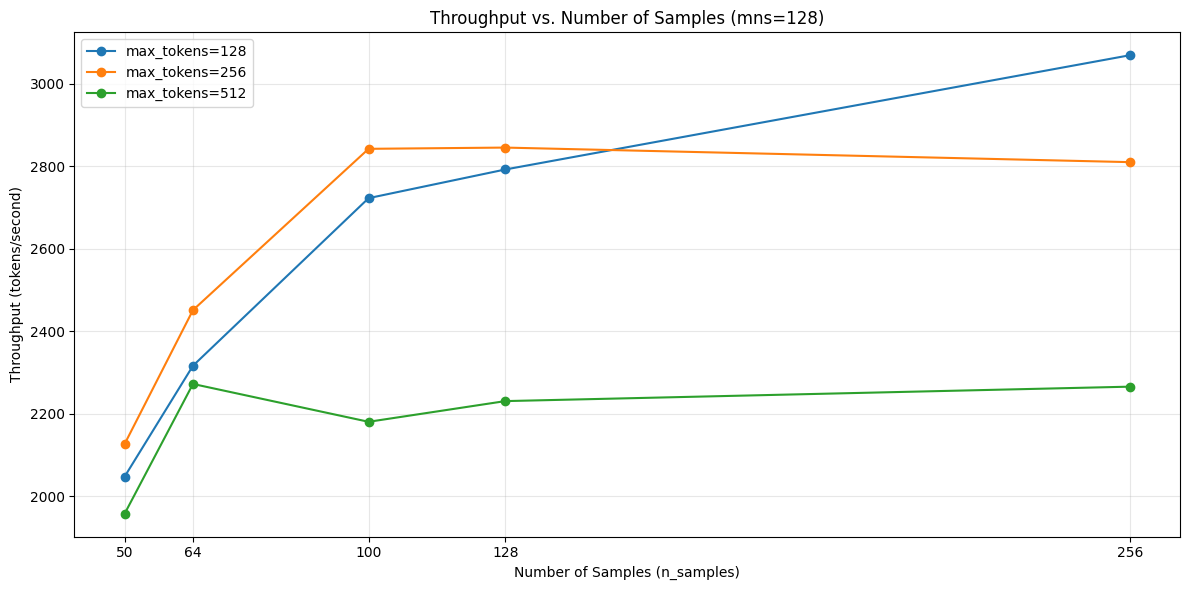

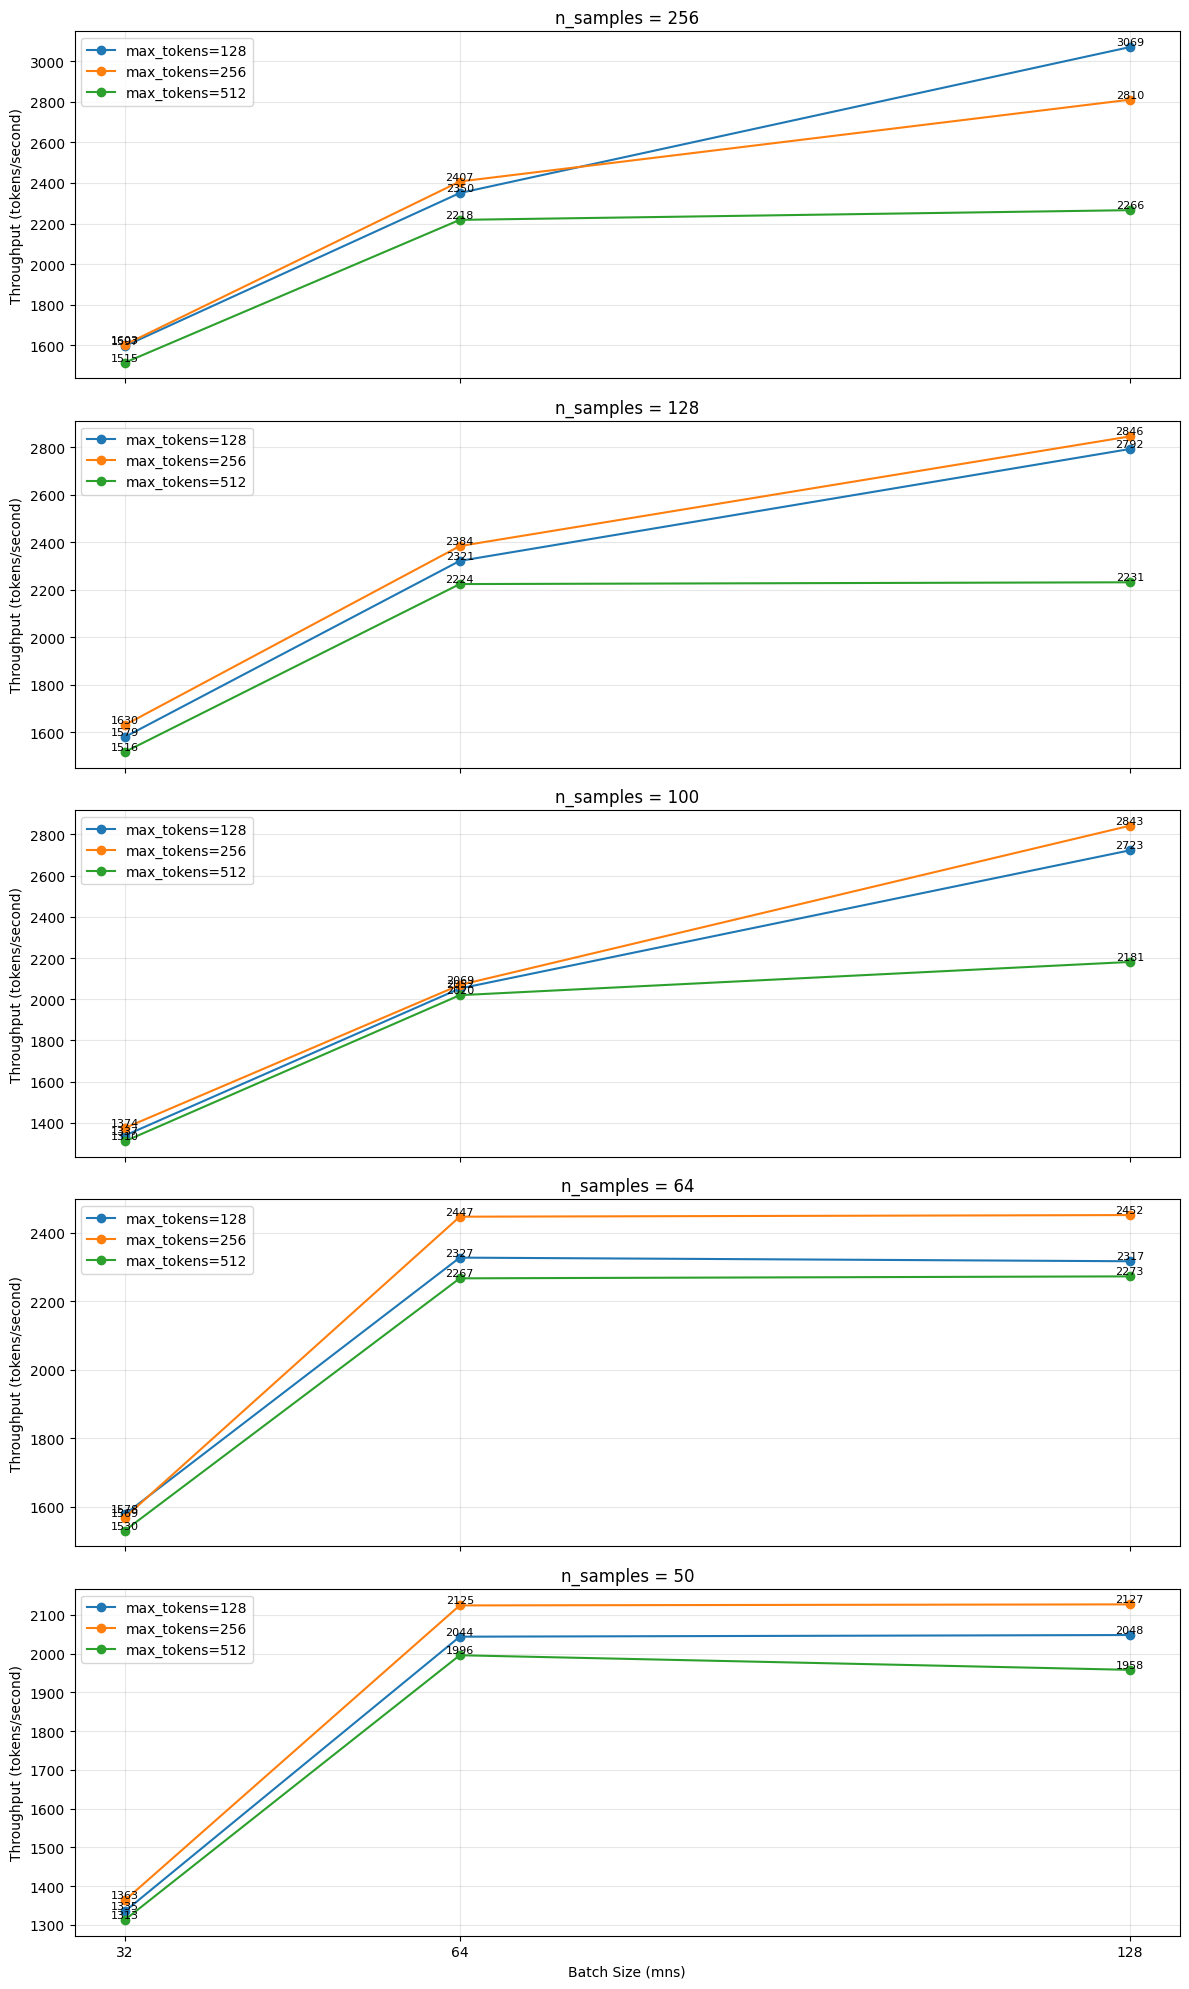

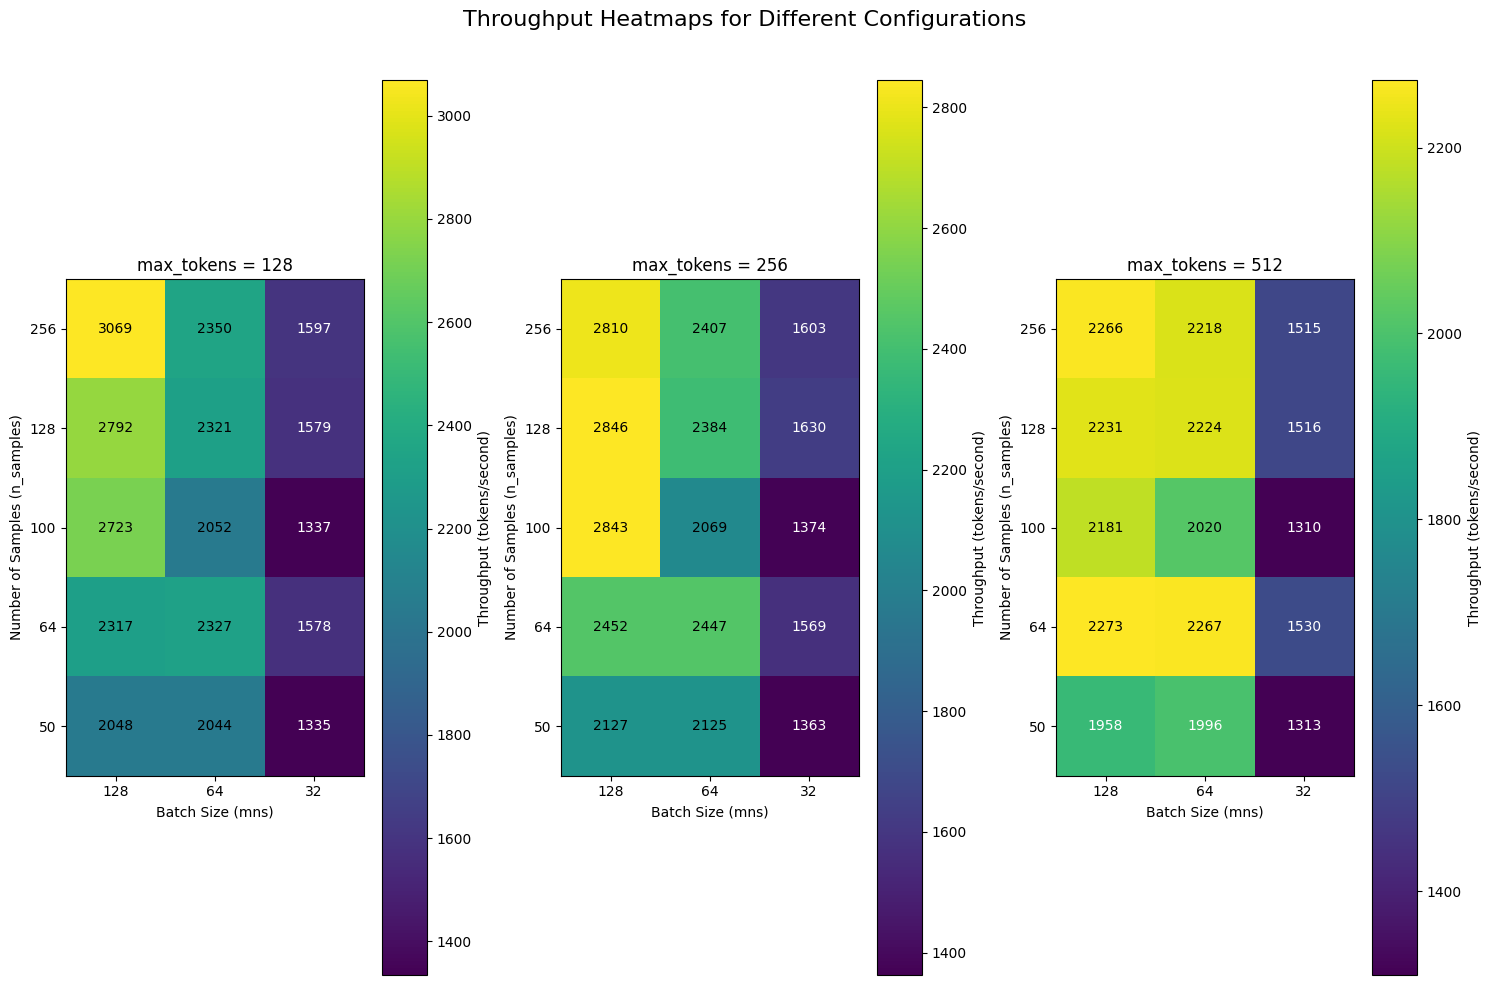

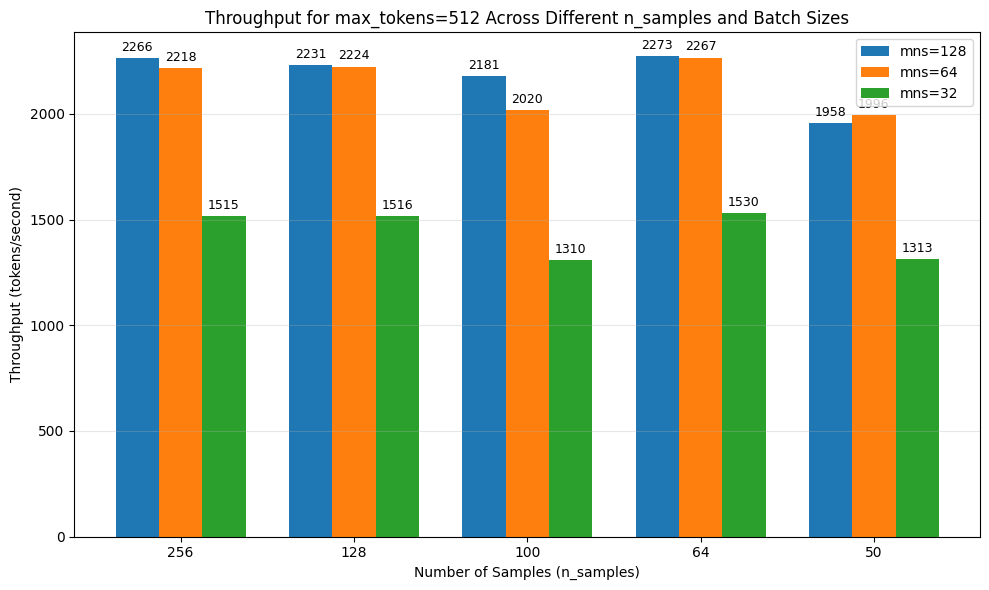

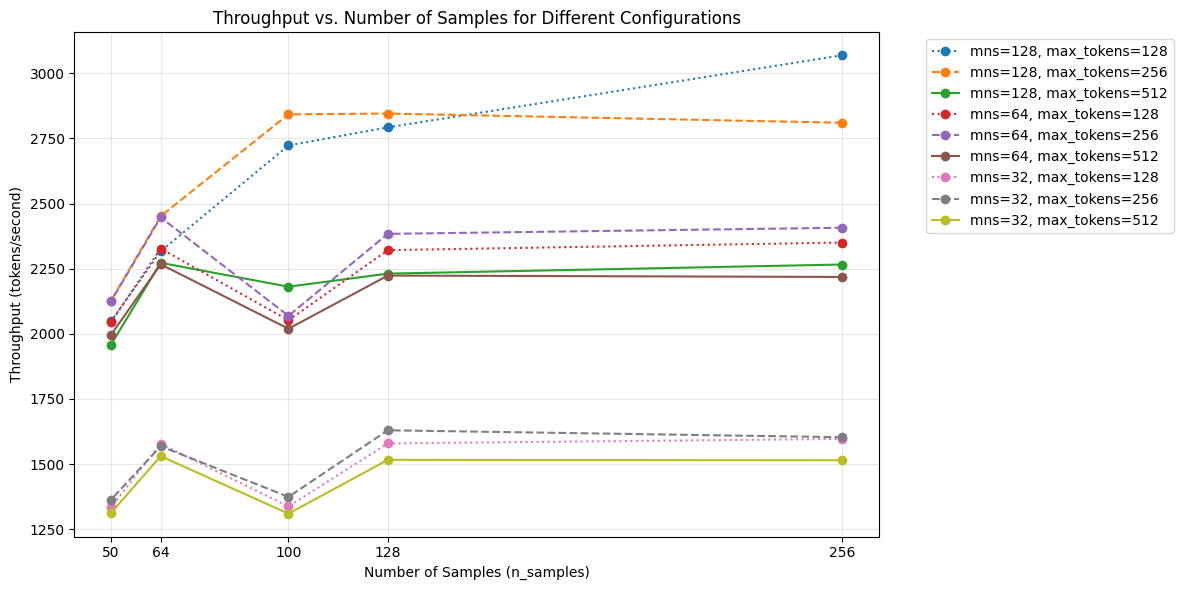

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict

# Load the data
filepath = '/workdir/experiments/exp6_diffN-queries/processed.csv'
df = pd.read_csv(filepath)

# Define the configuration parameters
n_samples_values = [256, 128, 100, 64, 50]
max_tokens_values = [128, 256, 512]
mns_values = [128, 64, 32]

# Create a structured dictionary to organize the data
throughput_data = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

# Fill the dictionary with throughput values
for _, row in df.iterrows():
    n_samples = row['n_samples']
    max_tokens = row['max_tokens']
    mns = row['mns']
    throughput = row['token_per_second']
    
    throughput_data[n_samples][max_tokens][mns] = throughput

# Create plots
# 1. First plot: Compare throughput across n_samples for each max_tokens (at mns=128)
plt.figure(figsize=(12, 6))

for max_tokens in max_tokens_values:
    throughputs = []
    for n_samples in n_samples_values:
        throughputs.append(throughput_data[n_samples][max_tokens][128])
    
    plt.plot(n_samples_values, throughputs, marker='o', label=f'max_tokens={max_tokens}')

plt.xlabel('Number of Samples (n_samples)')
plt.ylabel('Throughput (tokens/second)')
plt.title('Throughput vs. Number of Samples (mns=128)')
plt.grid(True, alpha=0.3)
plt.xticks(n_samples_values)
plt.legend()
plt.tight_layout()
plt.savefig('throughput_vs_n_samples_mns128.png', dpi=300)
plt.show()

# 2. Multiple plots: Compare throughput across batch sizes (mns) for each n_samples and max_tokens
fig, axes = plt.subplots(len(n_samples_values), 1, figsize=(12, 4*len(n_samples_values)), sharex=True)

for i, n_samples in enumerate(n_samples_values):
    ax = axes[i]
    
    # For each max_tokens value, plot throughput vs mns
    for max_tokens in max_tokens_values:
        throughputs = []
        for mns in mns_values:
            throughputs.append(throughput_data[n_samples][max_tokens][mns])
        
        ax.plot(mns_values, throughputs, marker='o', label=f'max_tokens={max_tokens}')
    
    ax.set_title(f'n_samples = {n_samples}')
    ax.set_ylabel('Throughput (tokens/second)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add value labels
    for max_tokens in max_tokens_values:
        for j, mns in enumerate(mns_values):
            throughput = throughput_data[n_samples][max_tokens][mns]
            ax.text(mns, throughput, f'{throughput:.0f}', 
                   ha='center', va='bottom', fontsize=8)

axes[-1].set_xlabel('Batch Size (mns)')
axes[-1].set_xticks(mns_values)
plt.tight_layout()
plt.savefig('throughput_comparison_all_configs.png', dpi=300)
plt.show()

# 3. Heatmap for easier comparison
plt.figure(figsize=(15, 10))

for i, max_tokens in enumerate(max_tokens_values):
    plt.subplot(1, len(max_tokens_values), i+1)
    
    data_matrix = np.zeros((len(n_samples_values), len(mns_values)))
    
    for j, n_samples in enumerate(n_samples_values):
        for k, mns in enumerate(mns_values):
            data_matrix[j, k] = throughput_data[n_samples][max_tokens][mns]
    
    im = plt.imshow(data_matrix, cmap='viridis')
    plt.colorbar(im, label='Throughput (tokens/second)')
    
    plt.yticks(range(len(n_samples_values)), n_samples_values)
    plt.xticks(range(len(mns_values)), mns_values)
    plt.ylabel('Number of Samples (n_samples)')
    plt.xlabel('Batch Size (mns)')
    plt.title(f'max_tokens = {max_tokens}')
    
    # Add text annotations with throughput values
    for j in range(len(n_samples_values)):
        for k in range(len(mns_values)):
            plt.text(k, j, f'{data_matrix[j, k]:.0f}', 
                    ha='center', va='center', color='white' if data_matrix[j, k] < 2000 else 'black')

plt.suptitle('Throughput Heatmaps for Different Configurations', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
plt.savefig('throughput_heatmaps.png', dpi=300)
plt.show()

# 4. Bar chart comparing throughput for all n_samples (focusing on mns=128 and max_tokens=512)
plt.figure(figsize=(10, 6))

x = np.arange(len(n_samples_values))
width = 0.25

for i, mns in enumerate(mns_values):
    throughputs = []
    for n_samples in n_samples_values:
        throughputs.append(throughput_data[n_samples][512][mns])
    
    offset = (i - 1) * width
    bars = plt.bar(x + offset, throughputs, width, label=f'mns={mns}')
    
    # Add value labels
    for j, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                f'{throughputs[j]:.0f}', ha='center', va='bottom', fontsize=9)

plt.xlabel('Number of Samples (n_samples)')
plt.ylabel('Throughput (tokens/second)')
plt.title('Throughput for max_tokens=512 Across Different n_samples and Batch Sizes')
plt.xticks(x, n_samples_values)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('throughput_max_tokens_512.png', dpi=300)
plt.show()

# 5. Line plot showing the relationship between n_samples and throughput for different mns values
plt.figure(figsize=(12, 6))

for mns in mns_values:
    for max_tokens in max_tokens_values:
        throughputs = []
        for n_samples in n_samples_values:
            throughputs.append(throughput_data[n_samples][max_tokens][mns])
        
        linestyle = '-' if max_tokens == 512 else ('--' if max_tokens == 256 else ':')
        plt.plot(n_samples_values, throughputs, marker='o', 
                 label=f'mns={mns}, max_tokens={max_tokens}',
                 linestyle=linestyle)

plt.xlabel('Number of Samples (n_samples)')
plt.ylabel('Throughput (tokens/second)')
plt.title('Throughput vs. Number of Samples for Different Configurations')
plt.grid(True, alpha=0.3)
plt.xticks(n_samples_values)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('throughput_vs_n_samples_all_configs.png', dpi=300)
plt.show()

In [3]:
os.path.abspath(os.path.curdir)  # Ensure the current working directory is set correctly

'/workdir'